# Given a list of camera poses, visualize them in a 3D scene

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pytorch3d.transforms as transformations
import sys, os
sys.path.append(os.path.dirname(os.path.abspath('')))
from utils.utils import *
import os.path as osp
import random
from datetime import datetime

# Part 1. Visualize camera poses using pyramids, in .txt (before converting to nerf format) and in .json (after converting to nerf format)

In [2]:
from utils.camera_pose_visualizer import CameraPoseVisualizer


In [3]:
# set the project directory and object dataset directory
parent_dir = os.path.dirname(os.getcwd())
obj_name = "onemarker_20240130_obj_frame"
obj_dir = osp.join(parent_dir, 'data', obj_name)
print(f"parent_dir: {parent_dir} \nobj_dir: {obj_dir}")

parent_dir: /data/ruihan/projects/NeRF-Texture 
obj_dir: /data/ruihan/projects/NeRF-Texture/data/onemarker_20240130_obj_frame


### Visualize poses in images.txt  (Before `nerf_invoke` converting to nerf format)

Visualize 205 camera poses in world frame
limit for all camera poses: x_min: -0.3848851720776952, x_max: 0.37565955815322016, y_min: -0.3813413753014348, y_max: 0.5569363065710858, z_min: 0.07134172936081142, z_max: 0.27567651302238955
initialize camera pose visualizer


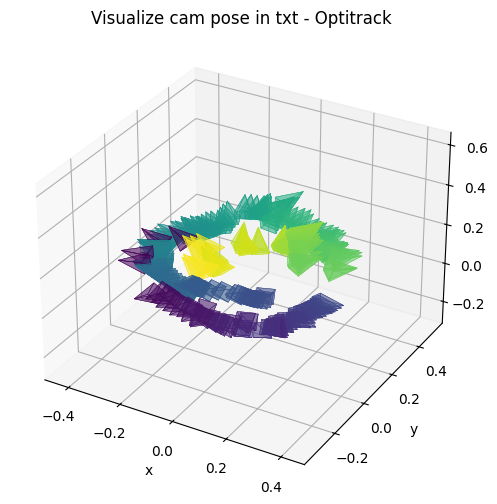

In [4]:
# Read images.txt and extract the camera poses
T_camerainworld_optitrack_txt = []
images_txt_file = "images_optitrack.txt" if "images_optitrack.txt" in os.listdir(obj_dir) else "images_all.txt"
images_txt_path = osp.join(obj_dir, images_txt_file)
with open(images_txt_path) as f:
    images_txt = f.readlines()
    images_txt = [x.strip() for x in images_txt]
    for i in range(len(images_txt)):
        if images_txt[i].startswith('#'):
            continue
        img_id, qw, qx, qy, qz, tx, ty, tz, cam_id, img_name = images_txt[i].split(' ')
        # convert (qw, qx, qy, qz, tx, ty, tz) to homogeneous transform matrix
        quat = np.array([float(qx), float(qy), float(qz), float(qw)])
        tvec = np.array([float(tx), float(ty), float(tz)])
        # convert to homogeneous transform matrix
        T_worldincamera = get_transform_matrix_from_quaternion(tvec, quat) # [4, 4]
        cam_pose = np.linalg.inv(T_worldincamera)
        T_camerainworld_optitrack_txt.append(cam_pose)

T_camerainworld_optitrack_txt = np.array(T_camerainworld_optitrack_txt)

visualize_cam_poses_3D(T_camerainworld_optitrack_txt, plt_title="Visualize cam pose in txt - Optitrack", save_plot=False, show_plot=True, save_path=f"logs/visualize_cam_poses_txt_optitrack_{obj_name}.png", focal_len_scaled=0.1)

Visualize 205 camera poses in world frame
limit for all camera poses: x_min: -4.223060785164357, x_max: 3.6616931673524413, y_min: -1.6580562557473164, y_max: 1.6371997697963652, z_min: -4.456131892163384, z_max: 4.2330050755374815
initialize camera pose visualizer


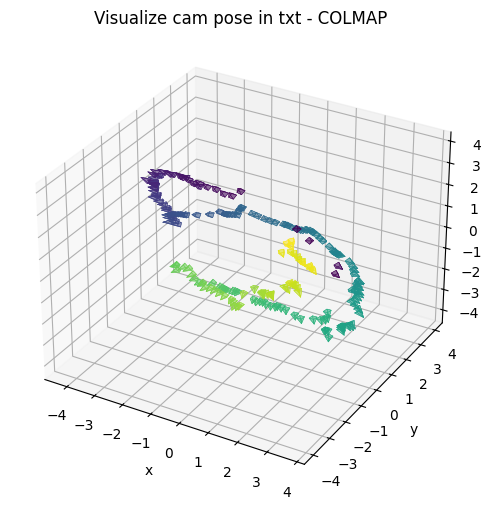

In [5]:
# Read images.txt and extract the camera poses
T_camerainworld_colmap_txt = []
images_txt_path = osp.join(obj_dir, 'colmap_text', 'images.txt')
img_ids = []
with open(images_txt_path) as f:
    images_txt = f.readlines()
    images_txt = [x.strip() for x in images_txt]
    for i in range(len(images_txt)):
        if images_txt[i].startswith('#'):
            continue
        if i % 2 == 0:
            img_id, qw, qx, qy, qz, tx, ty, tz, cam_id, img_name = images_txt[i].split(' ')
            # convert (qw, qx, qy, qz, tx, ty, tz) to homogeneous transform matrix
            quat = np.array([float(qx), float(qy), float(qz), float(qw)])
            tvec = np.array([float(tx), float(ty), float(tz)])
            # convert to homogeneous transform matrix
            T_worldincamera = get_transform_matrix_from_quaternion(tvec, quat) # [4, 4]
            cam_pose = np.linalg.inv(T_worldincamera)
            T_camerainworld_colmap_txt.append(cam_pose)
            img_ids.append(img_id)


# sort the camera poses according to the image id
T_camerainworld_colmap_txt = [x for _,x in sorted(zip(img_ids, T_camerainworld_colmap_txt), key=lambda pair: int(pair[0]))]

T_camerainworld_colmap_txt = np.array(T_camerainworld_colmap_txt)

visualize_cam_poses_3D(T_camerainworld_colmap_txt, plt_title="Visualize cam pose in txt - COLMAP", save_plot=False, show_plot=True, save_path=f"logs/visualize_cam_poses_txt_colmap_{obj_name}.png", focal_len_scaled=0.3)

### Visualize poses in transforms.json  (After generating .json file)

In [6]:
# Visualize camera poses in transforms_colmap.json
json_colmap = osp.join(obj_dir, 'transforms_colmap.json')
json_optitrack = osp.join(obj_dir, 'transforms_optitrack.json')

poses_colmap = extract_camera_poses_from_json(json_colmap)
poses_optitrack = extract_camera_poses_from_json(json_optitrack)

# flip each pose by a transform. X-right, Y-down, Z-forward changes to X-right, Y-up, Z-backward
flip_transform = np.array([[1, 0, 0, 0],
                           [0, -1, 0, 0],
                           [0, 0, -1, 0],
                           [0, 0, 0, 1]])

print(f"poses_colmap shape {poses_colmap.shape}, poses_optitrack shape {poses_optitrack.shape}")

poses_colmap shape (205, 4, 4), poses_optitrack shape (205, 4, 4)


Visualize 205 camera poses in world frame
limit for all camera poses: x_min: -4.696608601957363, x_max: 4.710417618405717, y_min: -4.245834228181974, y_max: 4.00574665100999, z_min: 0.7428944862372673, z_max: 2.7951561340726014
initialize camera pose visualizer


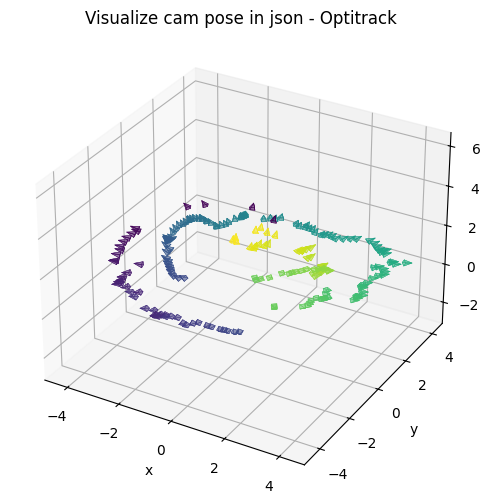

In [7]:
visualize_cam_poses_3D(poses_optitrack, plt_title="Visualize cam pose in json - Optitrack", save_plot=False, show_plot=True, save_path=f"logs/visualize_cam_poses_json_optitrack_{obj_name}.png", flip_transform=flip_transform, focal_len_scaled=0.3) # 

Visualize 205 camera poses in world frame
limit for all camera poses: x_min: -4.710913334513608, x_max: 4.713306543110993, y_min: -4.238675486743202, y_max: 4.000861387586629, z_min: 0.7571234970035896, z_max: 2.843924400558874
initialize camera pose visualizer


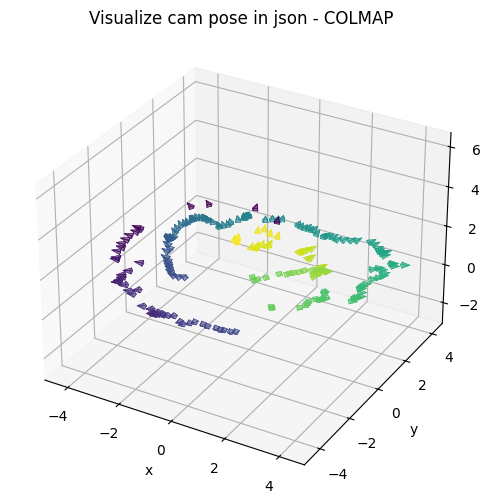

In [8]:
visualize_cam_poses_3D(poses_colmap, plt_title="Visualize cam pose in json - COLMAP", save_plot=False, show_plot=True, save_path=f"logs/visualize_cam_poses_json_colmap_{obj_name}.png", focal_len_scaled=0.3, flip_transform=flip_transform) # 
# Note: the cameras are reversed because NeRF coordinate convention for cameras are +X is right, +Y is up, and +Z is pointing back and away from the camera. -Z is the look-at direction., which is the same for OpenGL/Blender

## Part 2. Given two sets of poses, optitrack VS colmap, we estimate the relative transform between them and filter out the noisy frames. 
Noisy as in "large disagreement between two sets of poses / trajectories". 

In [9]:
from verify_homogeneous_transform import  evaluate_transform, estimate_transform

In [10]:
print(f"check shape poses_colmap {poses_colmap.shape}, poses_optitrack {poses_optitrack.shape}")

check shape poses_colmap (205, 4, 4), poses_optitrack (205, 4, 4)


check shape: selected_poses_colmap (199, 3), selelcted_poses_optitrack (199, 3)
check shape points_original: (199, 3) points_transformed: (199, 3)
centroid_original: (3,) [0.05133179 0.23470701 1.46840098]
after subtraction: centered_original: (199, 3) 
Check errors shape (199,), min 0.0040129411247970944, max 0.07706031913297998
check shape filtered_pts_index (154,), filted_out_pts_index (45,)
Find 154 points have error smaller than threshold, filter out 45 pts, index: [  0   5   6   8  10  11  14  16  22  23  28  29  31  34  35  39  41  46
  48  49  52  53  54  56  57  58  66  67  70  78  93  97 101 123 124 126
 130 135 142 143 158 180 188 193 194] 
In function evaluate_transform, 
Mean Squared Error: 0.0005778075515658967 
Total squared error 0.3449511082848404


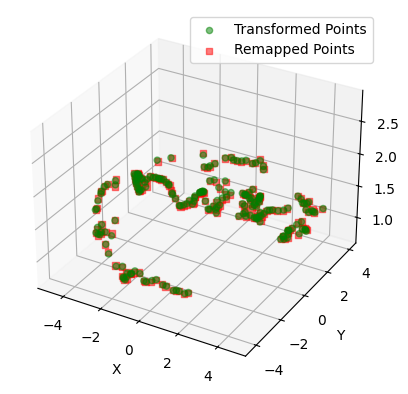

In [24]:
# Evaluate with all points 
all_poses_colmap = poses_colmap[:, :3, 3]
all_poses_optitrack = poses_optitrack[:, :3, 3]

all_indexes = np.arange(poses_colmap.shape[0])
exception_indexes = [6, 56, 57, 103, 174, 179]
selected_indexes = all_indexes[~np.isin(all_indexes, exception_indexes)]

selected_poses_colmap = all_poses_colmap[selected_indexes]
selected_poses_optitrack = all_poses_optitrack[selected_indexes]
print(f"check shape: selected_poses_colmap {selected_poses_colmap.shape}, selelcted_poses_optitrack {selected_poses_optitrack.shape}")

# # check shape points_original: (55, 3) points_transformed: (55, 3)
# # centroid_original: (3,) [ 0.052693   -1.37772379  0.57728615]

# all_poses_colmap = poses_colmap
# all_poses_optitrack = poses_optitrack
# check shape points_original: (55, 4, 4) points_transformed: (55, 4, 4)
# centroid_original: (4, 4) [[ 2.82130081e-01 -9.46511503e-11  3.74037681e-02  5.26929980e-02]
#  [ 3.37719244e-02  1.22118737e-11 -2.80435819e-01 -1.37772379e+00]
#  [ 7.81137720e-02  9.62534920e-01  1.48071263e-01  5.77286146e-01]
#  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

# obtain today's date
today = datetime.today().strftime("%Y%m%d")

# Transform = estimate_transform(all_poses_colmap, all_poses_optitrack, verbose=True)
Transform = estimate_transform(selected_poses_colmap, selected_poses_optitrack, verbose=True)
save_path = f"logs/{today}_found_naughty_frames_{obj_name}.png"
evaluate_transform(selected_poses_colmap, selected_poses_optitrack, Transform, save_plot=False, show_plot=True, draw_idx=True, save_path=save_path, rank_error=True, error_threshold=0.05, idx_list=[]) # , idx_list=exception_indexes

In [14]:
raise ValueError("Stop here to check")

ValueError: Stop here to check

## Part 3. After filtering out the index of inaccurate poses, remove them from current dataset (json file)

In [35]:
json_colmap = osp.join(obj_dir, 'transforms_colmap.json')
json_optitrack = osp.join(obj_dir, 'transforms_optitrack.json')

json_colmap_full = osp.join(obj_dir, f'transforms_colmap_full.json')
json_optitrack_full = osp.join(obj_dir, f'transforms_optitrack_full.json')


exception_indexes = [6, 56, 57, 103, 174, 179]


# # copy the file
# import shutil
# shutil.copy(json_colmap, json_colmap_full)
# shutil.copy(json_optitrack, json_optitrack_full)

# read the json file
import json
print(f"Updating {json_colmap}")
with open(json_colmap) as f:
    data_colmap = json.load(f)
    frames = data_colmap['frames']
    for frame in frames:
        if any(str(f"{exception_id:05d}") in frame["file_path"].split('/')[-1] for exception_id in exception_indexes):
            print(f"found exception id {frame['file_path']}")
            frames.remove(frame)
    data_colmap['frames'] = frames
# dump data_colmap to json file
with open(json_colmap, 'w') as f:
    json.dump(data_colmap, f)
    


print(f"Updating {json_optitrack}")
with open(json_optitrack) as f:
    data_optitrack = json.load(f)
    frames = data_optitrack['frames']
    for frame in frames:
        if any(str(f"{exception_id:05d}") in frame["file_path"].split('/')[-1] for exception_id in exception_indexes):
            print(f"found exception id {frame['file_path']}")
            frames.remove(frame)
    data_optitrack['frames'] = frames
# dump data_colmap to json file
with open(json_optitrack, 'w') as f:
    json.dump(data_optitrack, f)

Updating /data/ruihan/projects/NeRF-Texture/data/onemarker_20240130_obj_frame/transforms_colmap.json
Updating /data/ruihan/projects/NeRF-Texture/data/onemarker_20240130_obj_frame/transforms_optitrack.json
